## Weighted Least Squares

In [5]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

np.random.seed(42)
%matplotlib inline

## WLS Estimation
Fake data: Heteroscedascity of 2 groups

Assumptions:
1. Misspecification: true model will be quadratic, est. linear
1. Ind noise/error term
1. two groups for error variance, low and high var groups

In [6]:
nsample = 50
x = np.linspace(0,20, nsample)
X = np.column_stack((x, (x - 5)**2))
X = sm.add_constant(X)
beta = [5., 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6//10:]=3
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + sig * w * e
X = X[:,[0,1]]

## WLS knowing the true var ration of heteroscedasticity

In [7]:
mod_wls = sm.WLS(y, X, weights=1./(w**2))

In [8]:
res_wls = mod_wls.fit()
res_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.899
Model:                            WLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     429.3
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           1.38e-25
Time:                        14:27:31   Log-Likelihood:                -54.950
No. Observations:                  50   AIC:                             113.9
Df Residuals:                      48   BIC:                             117.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3106      0.154     34.502      0.000       5.001       5.620
x1             0.4033      0.019     20.720      0.000       0.364       0.442
==============================================================================
Omnibus:                        0.228   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.892   Jarque-Bera (JB):                0.132
Skew:                           0.119   Prob(JB):                        0.936
Kurtosis:                       2.920   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# OLS vs WLS

In [9]:
res_ols = sm.OLS(y, X).fit()
print(res_ols.params)
print(res_wls.params)

[5.55959672 0.36181418]
[5.31057184 0.40328365]


Compare WLS std error to hetero corrected OLS std errors

In [10]:
se = np.vstack([[res_wls.bse], [res_ols.bse], [res_ols.HC0_se], [res_ols.HC1_se], [res_ols.HC2_se],[res_ols.HC3_se] ])
se = np.round(se, 4)
colnames = ['x1', 'const']
rownames = ['WLS', 'OLS', 'OLS_HC0', 'OLS_HC1','OLS_HC2','OLS_HC3' ]
tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)

          x1   const 
---------------------
WLS     0.1539 0.0195
OLS     0.2907 0.0251
OLS_HC0 0.1863 0.0261
OLS_HC1 0.1901 0.0267
OLS_HC2 0.1923  0.027
OLS_HC3 0.1986 0.0278
---------------------


In [13]:
covb = res_ols.cov_params()
prediction_var = res_ols.mse_resid + (X * np.dot(covb, X.T).T).sum(1)
prediction_std = np.sqrt(prediction_var)
tppf = stats.t.ppf(0.975, res_ols.df_resid)

In [14]:
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)

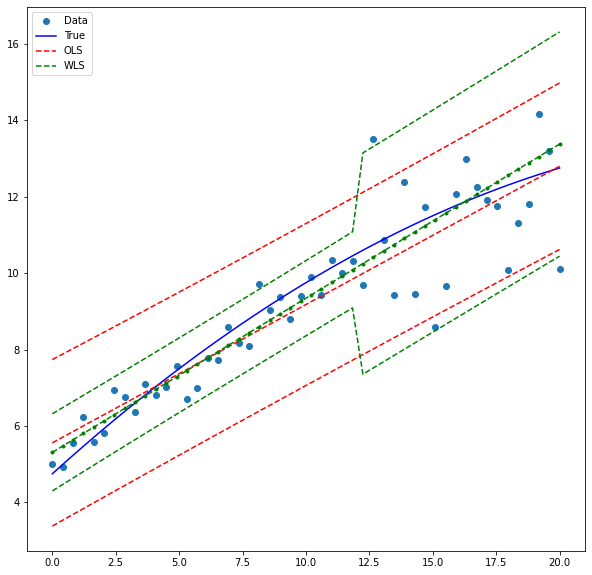

In [16]:
# Draw comparision between WLS and OLS
prstd, iv_1, iv_u = wls_prediction_std(res_wls)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, y, 'o', label="Data")
ax.plot(x, y_true, 'b-', label="True")
# OLS
ax.plot(x, res_ols.fittedvalues, 'r--')
ax.plot(x, iv_u_ols, 'r--', label="OLS")
ax.plot(x, iv_l_ols, 'r--')
# WLS
ax.plot(x, res_wls.fittedvalues, 'g--.')
ax.plot(x, iv_1, 'g--', label='WLS')
ax.plot(x, iv_u, 'g--')
ax.legend(loc="best");
